# AB testing mobile game

The goal of this project is to perform AB testing for data on a mobile game called Cookie Cats (by Tactile Entertainment). The game developer tried two different variantions of a 'level gate', which forces users to wait some time before they can continue. In this project, I will perform EDA, o 




1. Importing libraries;
2. Loading and first exploration of datasets;
3. Moving to SQL tables
4. EDA and hypothesis testing
5. Time-series analysis

Source: https://www.kaggle.com/competitions/rossmann-store-sales/data?select=store.csv

### 1. Importing libraries

In [241]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
from scipy.stats import mannwhitneyu

sns.set_theme(style="whitegrid")

### 2. EDA

In [2]:
df = pd.read_csv('cookie_cats.csv')
df.head(3)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False


1. Business problem
2. Clean data
3. EDA
4. Hypothesis testing
5. Evaluate

In [3]:
print('N samples: ',df.shape[0])
print('\nData types:\n',df.dtypes)

print('\nTarget value: sum_gamerounds')
print('Groups: ', df.version.unique())

print('\nNumber of users: ',df.userid.nunique())
print('Unique users:',df.userid.nunique()==df.shape[0])

print('\nMissing values: ',df.isna().any().sum())

N samples:  90189

Data types:
 userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

Target value: sum_gamerounds
Groups:  ['gate_30' 'gate_40']

Number of users:  90189
Unique users: True

Missing values:  0


In [4]:
print('Group distribution: \n',df.version.value_counts())

Group distribution: 
 gate_40    45489
gate_30    44700
Name: version, dtype: int64


The two groups are very similar in size, and having two groups allows for comparing the two different level gates while controlling for other variables (like seasonality or other trends).

In [5]:
df.groupby('version').sum_gamerounds.describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


In [117]:
def hist_and_box(df):
    fig, ax = plt.subplots(2,2, figsize = (6,6))

    for i,gate in enumerate(['gate_30','gate_40']):
        df[df.version == gate].sum_gamerounds.hist(ax = ax[0,i], bins = 50)
        ax[0,i].set_title(gate)

    sns.boxplot(data = df, y = 'sum_gamerounds', x = 'version', ax = ax[1,0])
    sns.boxplot(data = df, y = 'sum_gamerounds', x = 'version', showfliers = False, ax = ax[1,1])
    plt.tight_layout(pad=1, w_pad=1, h_pad=1.0)
    plt.show()

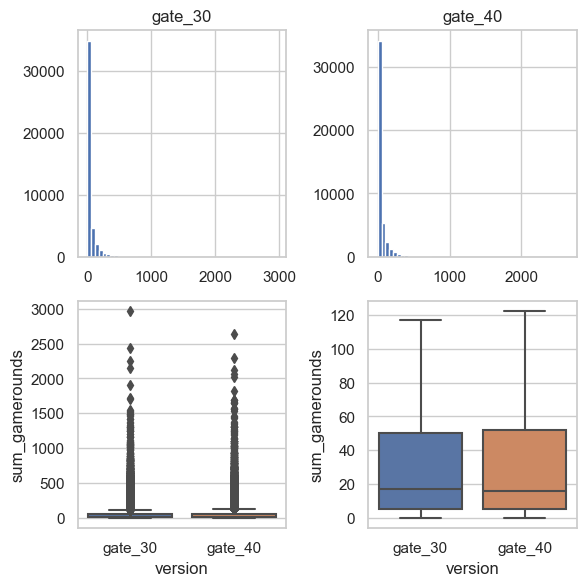

In [118]:
hist_and_box(df)

### 3. Dealing with outliers

We notice that there's some strong outliers, especially within the gate_30 group. Also, let's if there's a lot of / any users with 0 hours of gameplay:

In [77]:
gamerounds_df = pd.DataFrame(df[['version','sum_gamerounds']].value_counts()).reset_index().rename(columns = {0:'count'})
gamerounds_df[gamerounds_df.sum_gamerounds ==0]

,version,sum_gamerounds,count
5,gate_40,0,2057
6,gate_30,0,1937


In [90]:
gate_40_zero, gate_30_zero = gamerounds_df[gamerounds_df.sum_gamerounds ==0].iloc[:,-1].tolist()
print('gate_40: ',round(gate_40_zero/df[df.version =='gate_40'].shape[0],3),'%')
print('gate_30: ',round(gate_30_zero/df[df.version =='gate_30'].shape[0],3),'%')

gate_40:  0.045 %
gate_30:  0.043 %


There are quite some players who didn't play at all after installing the game. However, relative to the total number of users this amount is relatively small.

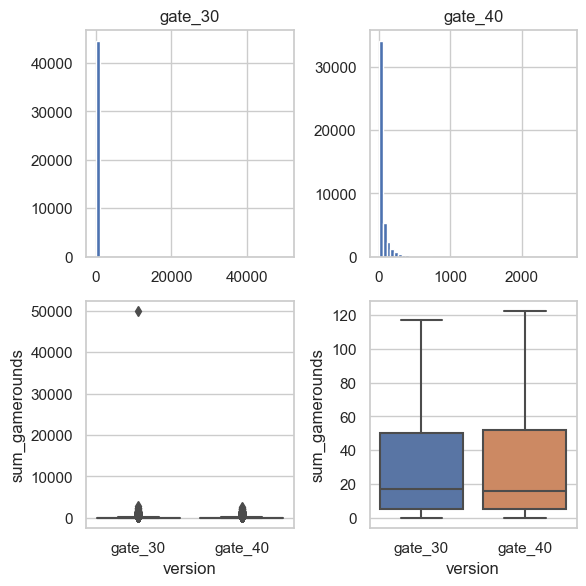

In [71]:
fig, ax = plt.subplots(2,2, figsize = (6,6))

for i,gate in enumerate(['gate_30','gate_40']):
    df[df.version == gate].sum_gamerounds.hist(ax = ax[0,i], bins = 50)
    ax[0,i].set_title(gate)

sns.boxplot(data = df, y = 'sum_gamerounds', x = 'version', ax = ax[1,0])
sns.boxplot(data = df, y = 'sum_gamerounds', x = 'version', showfliers = False, ax = ax[1,1])
plt.tight_layout(pad=1, w_pad=1, h_pad=1.0)
plt.show()

In [97]:
df[df.sum_gamerounds>3000]

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True


There seems to be one extreme outlier. As this extreme value could unrepresentably influence the outcome of a comparison test, I will remove it.

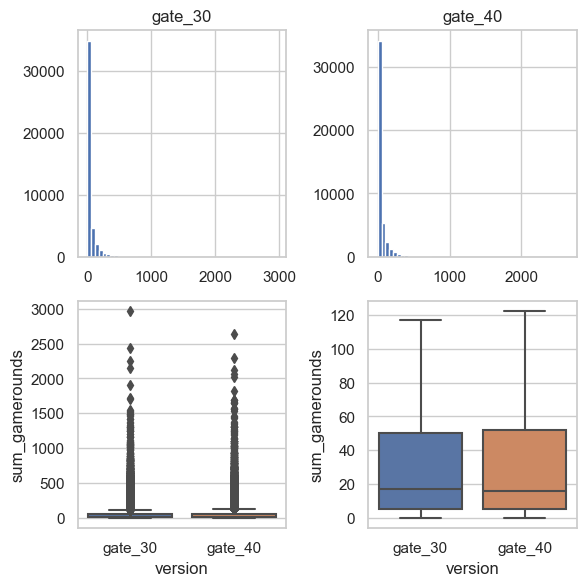

In [119]:
hist_and_box(df)

The data still shows a large amount of outliers. For determining outliers, there are (at least) two possible ways: using the z-score and using the inter-quartile range times 1.5. Let's see what applying these techniques would do:

In [108]:
from scipy import stats

df['z_score'] = np.abs(stats.zscore(df.sum_gamerounds))
df[df.z_score>3].sum_gamerounds.describe()

count    1849.000000
mean      567.443483
std       256.974819
min       360.000000
25%       411.000000
50%       488.000000
75%       617.000000
max      2961.000000
Name: sum_gamerounds, dtype: float64

In [110]:
df[df.sum_gamerounds>360].shape[0]

1840

Using the z-test, replacing values that have a z-score above 3 (3 times std), results in a upper limit of 360. However, there's one issues: the data is not normally distributed, so using a z-test is not very accurate. It would result in replacing 1840 samples.

In [113]:
quan1 = df.sum_gamerounds.quantile(.25)
quan3 = df.sum_gamerounds.quantile(.75)
itqr = quan3 - quan1

upper = quan3 + 1.5*itqr

print(upper)

120.0


In [114]:
df[df.sum_gamerounds>120].shape[0]

10176

Using the itqr x 1.5, results in an upper limit of 120. This limit would result in replacing 10176 samples.

In [115]:
df_new = df[df.sum_gamerounds<360]

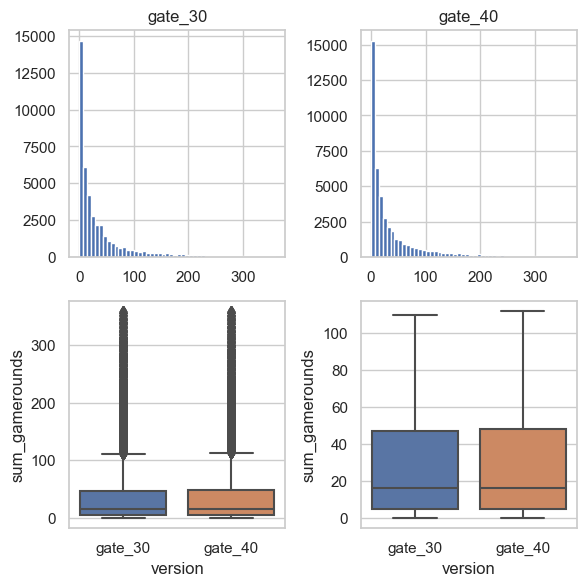

In [120]:
hist_and_box(df_new)

In [122]:
df_new.groupby('version').sum_gamerounds.describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,43770.0,40.537514,60.723443,0.0,5.0,16.0,47.0,359.0
gate_40,44569.0,40.497678,60.777671,0.0,5.0,16.0,48.0,359.0


Removing the outliers resulted in the two groups showing very little difference.

### 4. Retention

Now, let's also take a look at the retention differences between the groups.

In [226]:
pd.DataFrame({"count": df[['version','retention_1']].value_counts(),
              "ratio": df[['version','retention_1']].value_counts(normalize = True)}).reset_index().set_index('version')

,retention_1,count,ratio
version,,,
gate_40,False,25370,0.281301
gate_30,False,24665,0.273484
gate_40,True,20119,0.223078
gate_30,True,20034,0.222136


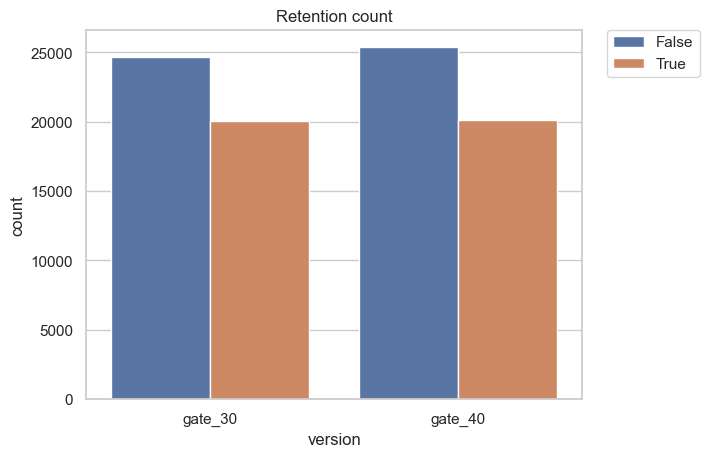

In [225]:
sns.countplot(data = df, x = 'version', hue = 'retention_1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Retention count');

In [227]:
pd.DataFrame({"count": df[['version','retention_7']].value_counts(),
              "ratio": df[['version','retention_7']].value_counts(normalize = True)}).reset_index().set_index('version')

,retention_7,count,ratio
version,,,
gate_40,False,37210,0.412583
gate_30,False,36198,0.401362
gate_30,True,8501,0.094259
gate_40,True,8279,0.091797


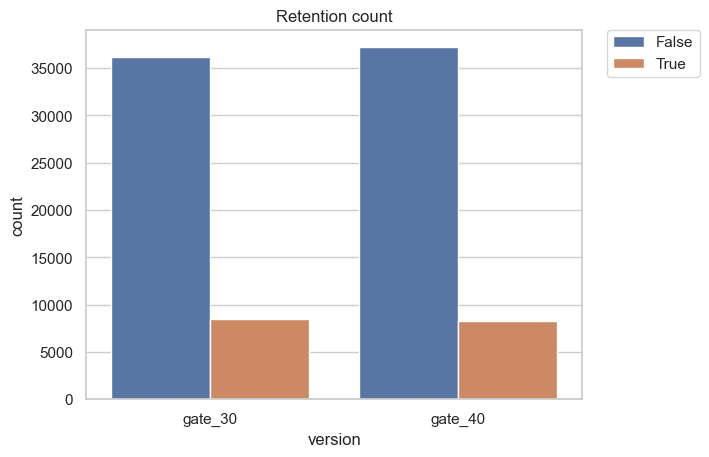

In [228]:
sns.countplot(data = df, x = 'version', hue = 'retention_7')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Retention count');

Differences between retention, for both 1 day and 7 days, are very small.

### 5. Hypothesis testing

The hypotheses for this testing are as follows:

$H_{0}: {\mu}(0) = {\mu}(1)$\
$H_{1}: {\mu}(0) ≠ {\mu}(1)$

Where 0 refers to group 'gate_30' and 1 to group 'gate_40'. I test to see whether there's enough evidence suggesting the mean sum_gamerounds are statistically different.

I will use:

${\alpha} = 0.05$

Which is a common value for alpha, related to a confidence of 95%.

Given the skewness of the data, I will be performing the Mann-Whitney U test, which is a non-parametric test. This means that the test doesn't assume a specific distribution (like a normal), and is therefore suitable for this data.

In [249]:
def hypothesis_test(df, alpha = 0.05):
    A = df[df.version == 'gate_30']['sum_gamerounds']
    B = df[df.version == 'gate_40']['sum_gamerounds']
    
    _,p = mannwhitneyu(A, B)
    
    if p >= alpha:
        print(f'Hypothesis 0 cannot be rejected [p ={round(p,4)}]')
    else:
        print(f'Hypothesis 0 can be rejected [p ={round(p,4)}]')

In [250]:
hypothesis_test(df_new)

Hypothesis 0 cannot be rejected [p =0.062]


The p-value is above the threshold of 0.05, which means there is not enough evidence to assume the two groups are not drawn from a population with the same distribution. That is, there is not enough evidence to say that a gate at level 30 will result in users playing for longer.

Now, to check whether removing the outliers had a significant effect on the final outcome:

In [251]:
hypothesis_test(df)

Hypothesis 0 cannot be rejected [p =0.0509]


It seems it did not. Although the p-value is lower, it is still above the threshold. If the p-value with outliers was belove the threshold, it would be a matter of deciding whether or not the set outlier threshold was correct. This is a decision that should be made on expertise and knowledge of the particular field, and should probably be made in advance to prevent bias (wanting a positive result).